In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse,signal,interpolate
from numpy import polynomial

import matplotlib.pyplot as plt


import sys
sys.path.insert(0, '..')

from partial_trace import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2
import os





Now, let's define our system.
We will consider a spin Hamiltonain
$$
\vec{H} := \sum_{i,j=1}^{N} \left[  J^{\text{x}}_{i,j} \vec{\sigma}^{\text{x}}_i \vec{\sigma}^{\text{x}}_j 
    +J^{\text{y}}_{i,j} \vec{\sigma}^{\text{y}}_i \vec{\sigma}^{\text{y}}_j
    +J^{\text{z}}_{i,j} \vec{\sigma}^{\text{z}}_i \vec{\sigma}^{\text{z}}_j \right] 
    + \frac{h}{2} \sum_{i=1}^{N} \vec{\sigma}_i^{\text{z}}
$$
In the case $\vec{J}^{\text{z}}_{i,j} = 0$ and 
$$
\vec{J}^{\text{x/y}}_{i,j} = \begin{cases} 0 & |i-j| = 0 \\ \frac{1}{||i-j||^{\alpha}} & \text{otherwise} \end{cases}
$$

We will use with $\alpha = 1, 2, 10$. and N is set to 16. 

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

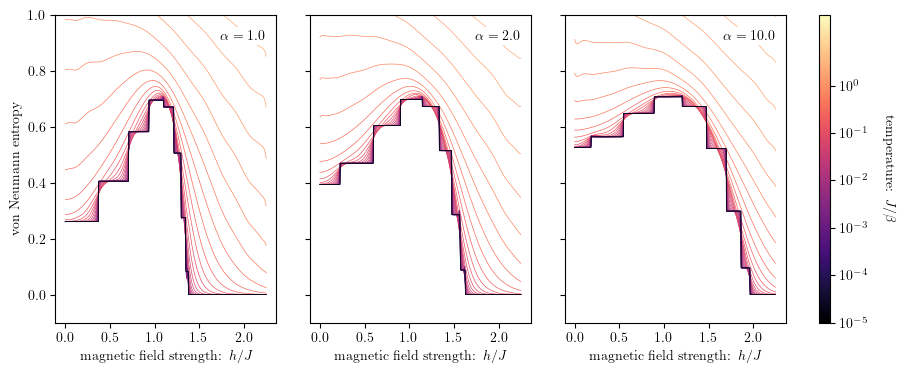

In [4]:
fig,axs = plt.subplots(1,4,figsize=(10,4),gridspec_kw={'width_ratios': [1,1,1,.05]})

# αs = [1]
αs = [1.,2.,10.]
# αs = [15]

for αi,α in enumerate(αs):
    
    directory = f'data/chain_{α}'
    
    # load parameters
    [s,N,N_s] = np.load(f'{directory}/dimensions.npy',allow_pickle=True)
    N = int(N)
    N_s = int(N_s)
    
    out_all = []
    hs = []
    for file in os.listdir(f'{directory}/data'):
        
        # only look at npy files
        if file[-4:] != '.npy':
            continue
        
        data = np.load(f'{directory}/data/{file}',allow_pickle=True).item()
        hs.append(data['h'])
        out_all.append(data['out'])
    
    hs,out_all = zip(*sorted(zip(hs,out_all)))
    hs = np.array(hs)
    
    
    n_βs = 30
    βs = np.hstack([[1e5,1e4],1/np.logspace(-3,.5,n_βs-2)])
    
    
    vN_entropy_all = []
    for hi,h in enumerate(hs):
    
        (Λk,Tr_defl),(Θs,Tr_rems) = out_all[hi]
        E0 = Λk[0]
    
        vN_entropy = get_vN_entropy(Λk,Tr_defl,Θs,Tr_rems,E0,βs)
        vN_entropy_all.append(vN_entropy)
    
    hs_full = np.linspace(hs[0],hs[-1],500)
    
    turning_points = np.load(f'{directory}/turning_points.npy')
    
    βs_to_int = lambda β: (np.log10(βs[0]) - np.log10(β)) / (np.log10(βs[0])-np.log10(βs[-1]/10))
        
    for l,β in enumerate(βs[::-1]):
        c = plt.cm.magma(βs_to_int(β)) 
    
        # get y values for a single temperature
        y = np.array(vN_entropy_all)[:,-l-1]
    
        if β < 8e0:
            deg = 20
            p = polynomial.chebyshev.Chebyshev.fit(hs,y,deg)
            axs[αi].plot(hs_full,p(hs_full),color=c,lw=.5)

        elif β < 5e2:
            tck = sp.interpolate.splrep(hs,y,s=0)
            axs[αi].plot(hs_full,sp.interpolate.BSpline(*tck)(hs_full),color=c,lw=.5)
        else:
            axs[αi].plot(hs,y,color=c,lw=.5)
    

    cmap = plt.get_cmap('magma')
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    Ts = np.array([1e-5,1e-4,1e-3,1e-2,1e-1,1e0])
    cbar = plt.colorbar(sm,ticks=βs_to_int(1/Ts),cax=axs[-1])
    cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(T))}}}$' for T in Ts]);  # vertically oriented colorbar
    axs[-1].set_ylabel('temperature: $J/\\beta$',rotation=-90, labelpad=20)
    

    axs[αi].set_ylim(-.1,1)
    axs[αi].set_xlabel('magnetic field strength: $h/J$')
        
    axs[αi].text(.95,.95,rf'$\alpha={α}$',ha='right', va='top', transform=axs[αi].transAxes,bbox=dict(facecolor='white',edgecolor='none',pad=2))

    if αi>0:
        axs[αi].set_yticklabels([])

axs[0].set_ylabel('von Neumann entropy')

plt.savefig(f'imgs/vN_phase_greater_alpha.pdf')

$\renewcommand{\vec}{\mathbf}$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


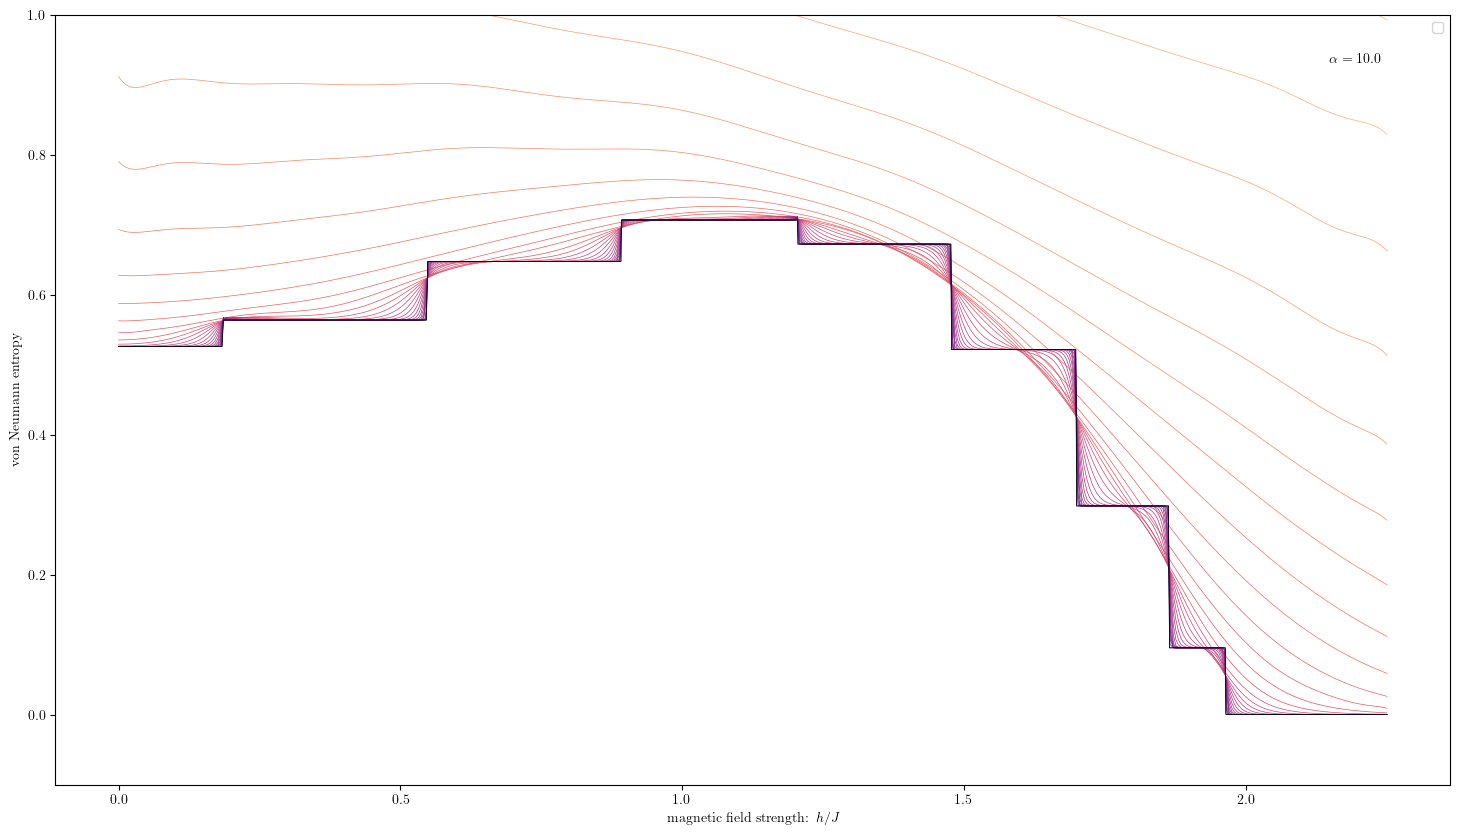

In [9]:
import numpy as np
import os
import scipy as sp
from numpy import polynomial
import matplotlib.pyplot as plt

# Removed unnecessary imports to simplify the example

# Setup the single subplot
fig, ax = plt.subplots(figsize=(18, 10))

# Only use the first value of αs
α = 10.0

directory = f'data/chain_{α}'

# Load parameters
[s, N, N_s] = np.load(f'{directory}/dimensions.npy', allow_pickle=True)
N = int(N)
N_s = int(N_s)

out_all = []
hs = []
for file in os.listdir(f'{directory}/data'):
    # Only look at npy files
    if file[-4:] != '.npy':
        continue

    data = np.load(f'{directory}/data/{file}', allow_pickle=True).item()
    hs.append(data['h'])
    out_all.append(data['out'])

hs, out_all = zip(*sorted(zip(hs, out_all)))
hs = np.array(hs)

n_βs = 30
βs = np.hstack([[1e5, 1e4], 1/np.logspace(-3, .5, n_βs-2)])

vN_entropy_all = []
for hi, h in enumerate(hs):
    (Λk, Tr_defl), (Θs, Tr_rems) = out_all[hi]
    E0 = Λk[0]
    vN_entropy = get_vN_entropy(Λk, Tr_defl, Θs, Tr_rems, E0, βs)
    vN_entropy_all.append(vN_entropy)

hs_full = np.linspace(hs[0], hs[-1], 500)

# Skipping the loading of turning_points since it's not being used in the given code
# turning_points = np.load(f'{directory}/turning_points.npy')

βs_to_int = lambda β: (np.log10(βs[0]) - np.log10(β)) / (np.log10(βs[0]) - np.log10(βs[-1]/10))

for l, β in enumerate(βs[::-1]):
    c = plt.cm.magma(βs_to_int(β))
    # Get y values for a single temperature
    y = np.array(vN_entropy_all)[:,-l-1]

    if β < 8e0:
        deg = 20
        p = polynomial.chebyshev.Chebyshev.fit(hs, y, deg)
        ax.plot(hs_full, p(hs_full), color=c, lw=.5)
    elif β < 5e2:
        tck = sp.interpolate.splrep(hs, y, s=0)
        ax.plot(hs_full, sp.interpolate.BSpline(*tck)(hs_full), color=c, lw=.5)
    else:
        # print("check")
        ax.plot(hs, y, color=c, lw=.5)

ax.set_ylim(-.1, 1)
ax.set_xlabel('magnetic field strength: $h/J$')
ax.set_ylabel('von Neumann entropy')
ax.text(.95, .95, rf'$\alpha={α}$', ha='right', va='top', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='none', pad=2))
ax.legend()


plt.savefig(f'imgs/vN_phase_alpha_{α}.pdf')


In [10]:
turning_points

array([0.        , 0.18347168, 0.18566895, 0.54602051, 0.54821777, 0.89099121, 1.2052002 , 1.47766113, 1.69958496, 1.86218262, 1.96325684, 2.25      ])

In [16]:
len(y)==len(hs)

True

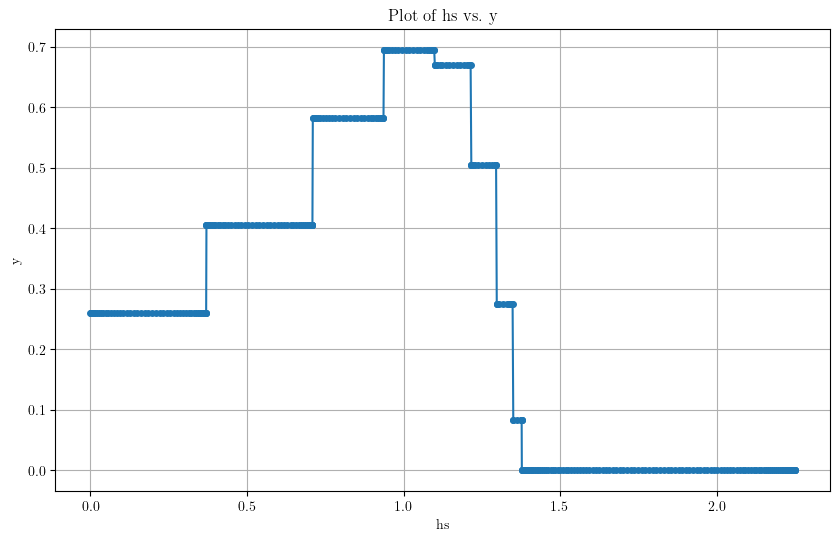

In [7]:
# Plotting hs vs. y
plt.figure(figsize=(10, 6))
plt.plot(hs, y, '-o', markersize=4)
plt.xlabel('hs')
plt.ylabel('y')
plt.title('Plot of hs vs. y')
plt.grid(True)
plt.show()

In [25]:
hs[160]

1.126565968322275

In [8]:
# Define the thresholds
hs_threshold = 0.1  # Adjust as needed
y_threshold = 0.01  # Adjust as needed

# Identify points where hs values are extremely close, but y values differ a lot
for i in range(1, len(hs)):
    hs_diff = abs(hs[i] - hs[i-1])
    y_diff = abs(y[i] - y[i-1])
    
    if hs_diff < hs_threshold and y_diff > y_threshold:
        print(f"hs values: {hs[i-1]} and {hs[i]} are extremely close with a difference: {hs_diff}")
        print(f"However, their corresponding y values: {y[i-1]} and {y[i]} differ by: {y_diff}")
        print("-----")
    



hs values: 0.3693838409164379 and 0.37014414634623327 are extremely close with a difference: 0.0007603054297953826
However, their corresponding y values: 0.26044600002594803 and 0.40485943227225063 differ by: 0.1444134322463026
-----
hs values: 0.7087747504235496 and 0.7100248673343447 are extremely close with a difference: 0.0012501169107950183
However, their corresponding y values: 0.4048594334302138 and 0.581610939226318 differ by: 0.1767515057961042
-----
hs values: 0.9357270857906554 and 0.9369772027014504 are extremely close with a difference: 0.0012501169107949073
However, their corresponding y values: 0.5816109392263235 and 0.6945458769248367 differ by: 0.11293493769851326
-----
hs values: 1.0976931139542352 and 1.09950411730013 are extremely close with a difference: 0.0018110033458949015
However, their corresponding y values: 0.694545876924838 and 0.6698448674134707 differ by: 0.024701009511367333
-----
hs values: 1.2139892578125 and 1.2158675468860676 are extremely close with

In [19]:
# Count the number of points in hs between 1.06 and 1.07
count = np.sum((hs >= 1.06) & (hs <= 1.07))
print(f"There are {count} points in 'hs' between 1.06 and 1.07.")

There are 8 points in 'hs' between 1.06 and 1.07.
